In [2]:
# Import train_test_split function
from matplotlib.colors import LogNorm, Normalize
from qupath_processing.utilities import get_image_to_exlude_list
#Import Models
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
import numpy.testing as npt
#Import scikit-learn metrics module for accuracy calculation
import os
import IPython
from IPython.display import Image
from ipywidgets import Output, HBox, VBox, Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
import argparse
import re
import random
import glob
%matplotlib inline

In [4]:
datapath = "/gpfs/bbp.cscs.ch/project/proj53/CellDensitiesProject/Production/2024/Dataframes/Per_depth_density/"
verbose=True
figure_path = "/gpfs/bbp.cscs.ch/project/proj53/LayerBoundariesProject/Production/PaperPlots/stero exclusion/2024" 

In [5]:
used_file_path = '/gpfs/bbp.cscs.ch/project/proj53/CellDensitiesProject/Production/2024/Density/02022024/Per_percentage/'
used_file_list = glob.glob(used_file_path + '/SLD*')
print(len(used_file_list), used_file_list[0])

218 /gpfs/bbp.cscs.ch/project/proj53/CellDensitiesProject/Production/2024/Density/02022024/Per_percentage/SLD_0000752.vsi-20x_01.csv


In [6]:
image_to_exlude_path = ('/gpfs/bbp.cscs.ch/data/project/proj53/LayerBoundariesProject/Analysis/Exclude-ID_v20240206jm.xlsx')
df_image_to_exclude = pd.read_excel(image_to_exlude_path, index_col=0, skiprows=[0,1,2,3,4,5,6,7])
db_image_to_exlude_list = get_image_to_exlude_list(df_image_to_exclude)

cleaned_filelist = used_file_list.copy()
for file in used_file_list:
    for image_to_remove in db_image_to_exlude_list:
        if file.find(image_to_remove) > -1:
            try:
                cleaned_filelist.remove(file)
            except ValueError:
                print(file)
            continue


In [7]:
used_file_list = cleaned_filelist
len(used_file_list)

199

In [8]:
correct_file_list = []
source_path = '/gpfs/bbp.cscs.ch/project/proj53/CellDensitiesProject/Production/2024/Dataframes/Per_depth_density/'
for file in used_file_list:
    file =  'Features_' + file[file.rfind('/')+1:]
    correct_file_list.append(source_path  + file)

In [9]:
single_slice_df = pd.read_csv(correct_file_list[0], index_col=0)

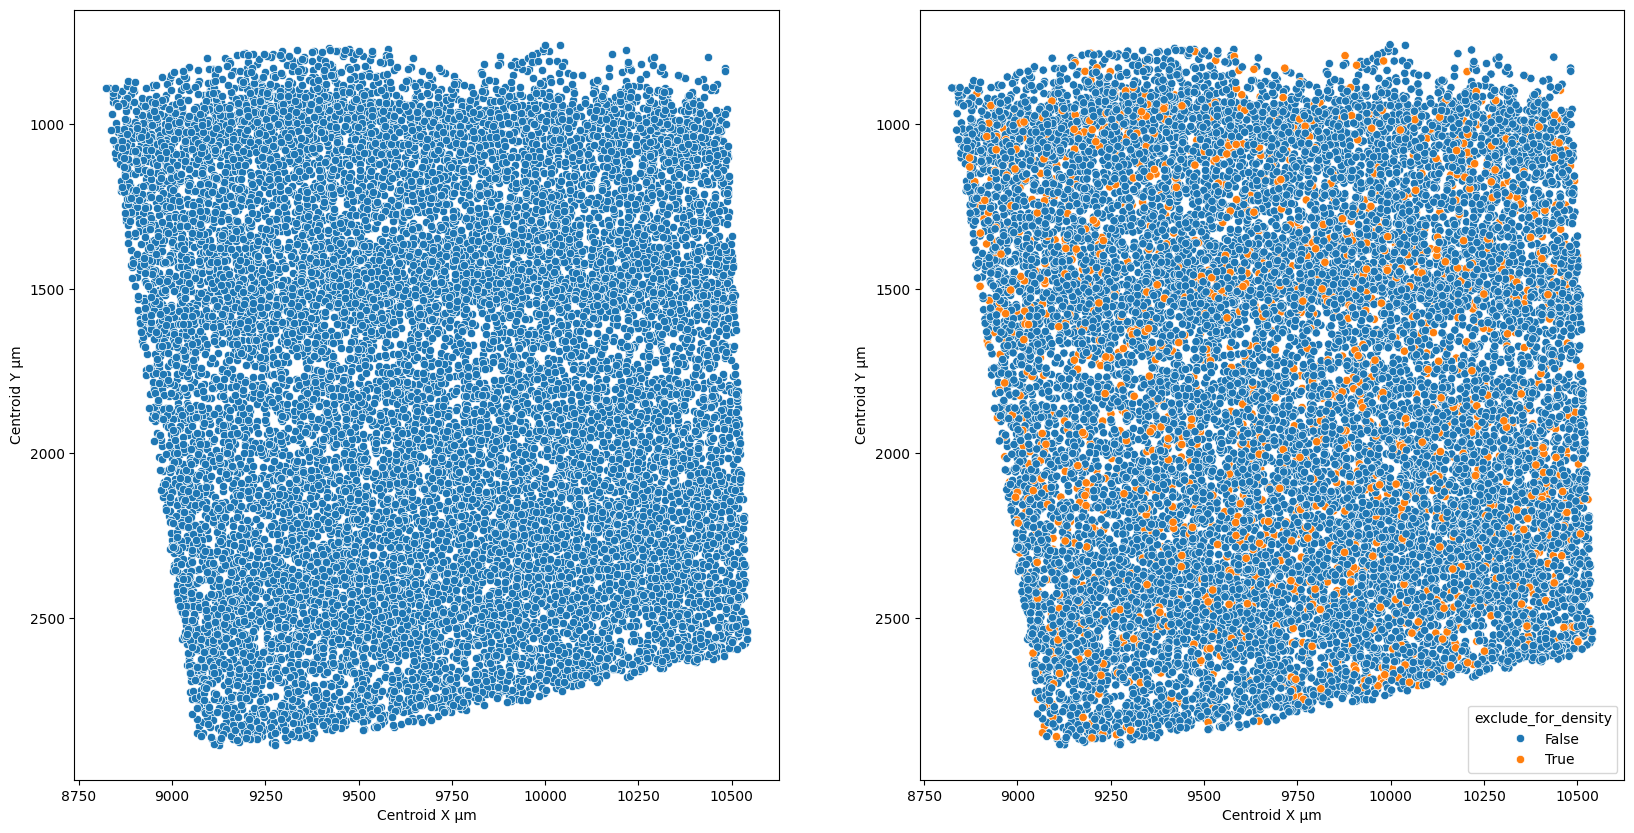

In [10]:
fig, ax = plt.subplots(1,2,figsize=(20,10))

ax[0].invert_yaxis()
ax[1].invert_yaxis()
sns.scatterplot(data=single_slice_df,x="Centroid X µm",y="Centroid Y µm",ax=ax[0])
sns.scatterplot(data=single_slice_df,x="Centroid X µm",y="Centroid Y µm",hue='exclude_for_density',ax=ax[1])

plt.savefig(figure_path +  '/exclude_cells.svg')

In [11]:
frames = []
for file in correct_file_list:
    frames.append(pd.read_csv(file, index_col=0))
slice_df = pd.concat(frames, ignore_index=True)    

In [13]:
exclude_slice_df = slice_df[slice_df['exclude_for_density']==True]

In [16]:
distances_to_pia = exclude_slice_df["Distance to annotation with Outside Pia µm"].values

In [17]:
diameters = exclude_slice_df["Max diameter µm"].values

In [18]:
slice_df.groupby('Image').size()
#slice_df.groupby('Image').groupby('exclude_for_density')
counts = slice_df.groupby(['Image', 'exclude_for_density'])['exclude_for_density'].aggregate('count').to_numpy().reshape(-1,2)
fraction_of_exclude =counts[:,1] / counts[:,0]

In [20]:
NmeanDetectedCells = slice_df.groupby(['Image'])['Image'].aggregate('count').mean()
NmeanExcludedCells = counts[:,1].mean()
Nimages = len(correct_file_list)
nb_detexted_cells = counts.sum()
excluded = counts[:,1].sum() / nb_detexted_cells * 100
print(f' A total of {excluded:.2f}% of the cells were excluded from the analysis \
Nimages={Nimages}, NmeanDetectedCells={NmeanDetectedCells:.2f}, \
NmeanExcludedCells={NmeanExcludedCells:.2f}')

 A total of 9.79% of the cells were excluded from the analysis Nimages=199, NmeanDetectedCells=13690.12, NmeanExcludedCells=1340.15


Text(0.5, 0, 'Distance to pia (μm)')

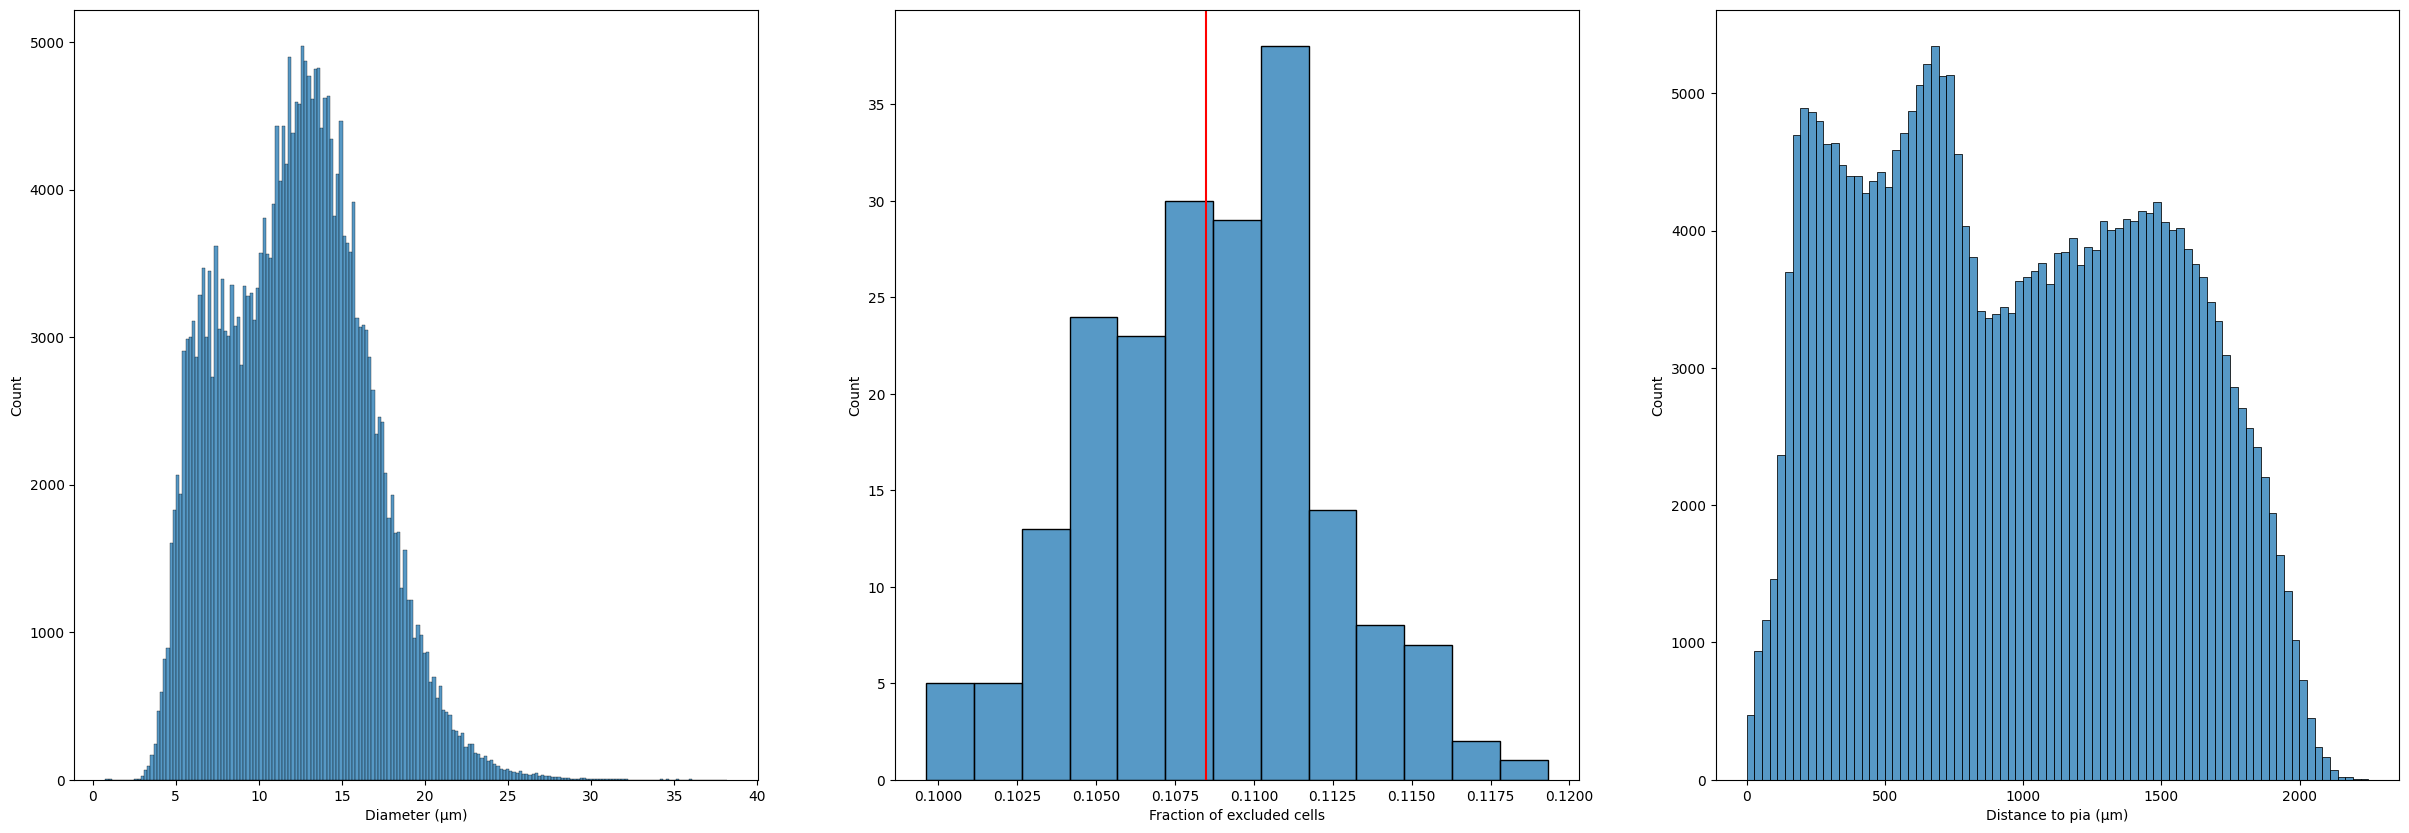

In [21]:
fig, ax = plt.subplots(1,3,figsize=(30,10))
sns.histplot(diameters,ax=ax[0])
ax[0].set_xlabel(f"Diameter (μm)")
sns.histplot(fraction_of_exclude ,ax=ax[1])
ax[1].set_xlabel("Fraction of excluded cells")
ax[1].axvline(x=fraction_of_exclude.mean() ,color='red')

sns.histplot(distances_to_pia,ax=ax[2])
ax[2].set_xlabel(f'Distance to pia (μm)')

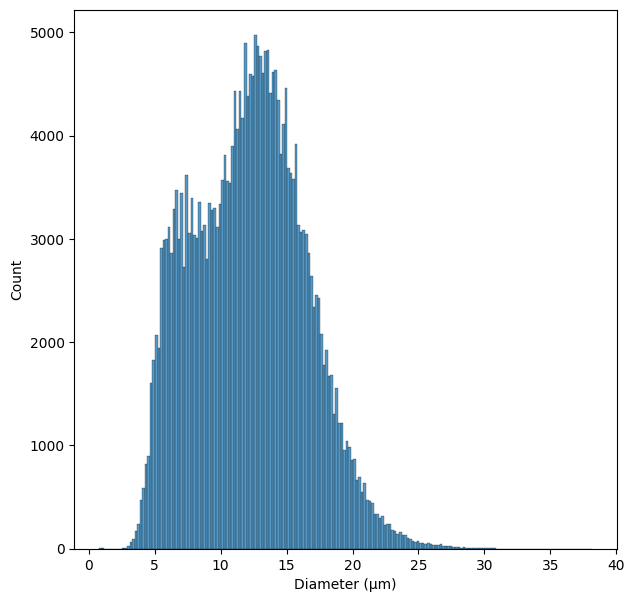

In [22]:
plt.figure(figsize=(7,7))
sns.histplot(diameters, ax=plt.gca())
plt.xlabel(f"Diameter (μm)")
plt.savefig(figure_path +  '/diameter.svg')

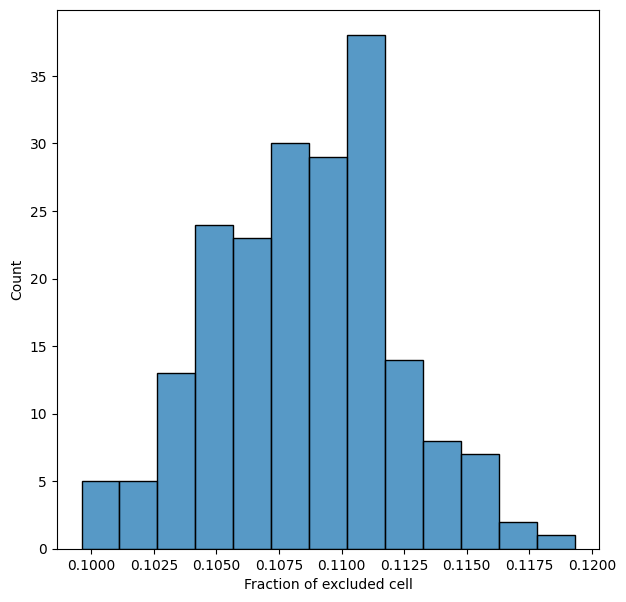

In [23]:
plt.figure(figsize=(7,7))
sns.histplot(fraction_of_exclude, ax=plt.gca())

plt.xlabel(f"Fraction of excluded cell")
plt.savefig(figure_path +  '/fraction.svg')

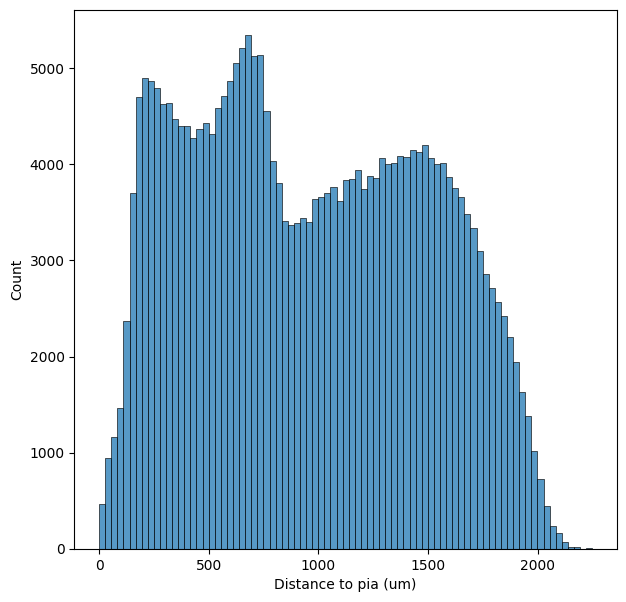

In [24]:
plt.figure(figsize=(7,7))
sns.histplot(distances_to_pia, ax=plt.gca())

plt.xlabel("Distance to pia (um)")
plt.savefig(figure_path +  '/distace_to_pia.svg')

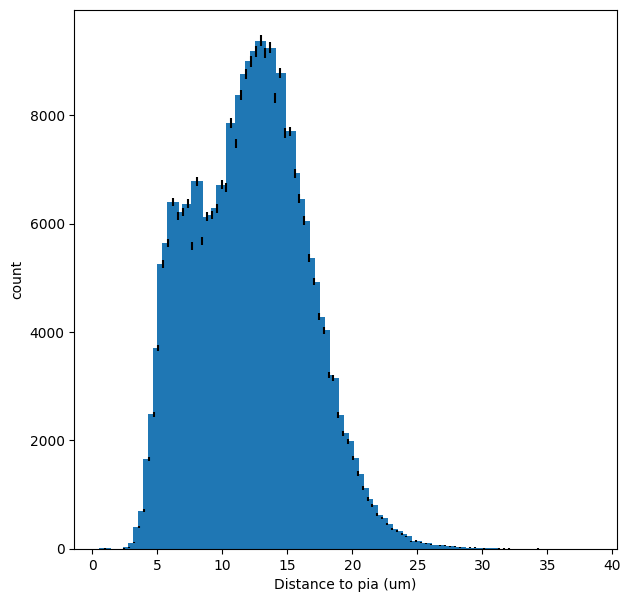

In [25]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
data       = diameters
bins = 100#int(np.sqrt(data.shape[0]))-1
y,binEdges = np.histogram(data,bins=bins)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
menStd     = np.sqrt(y)
width      = 0.9
plt.bar(bincenters, y, width=width, yerr=menStd)
plt.xlabel(f"Distance to pia (um)")
plt.ylabel("count")
plt.show()
#plt.savefig(figure_path +  '/Diameter.svg')

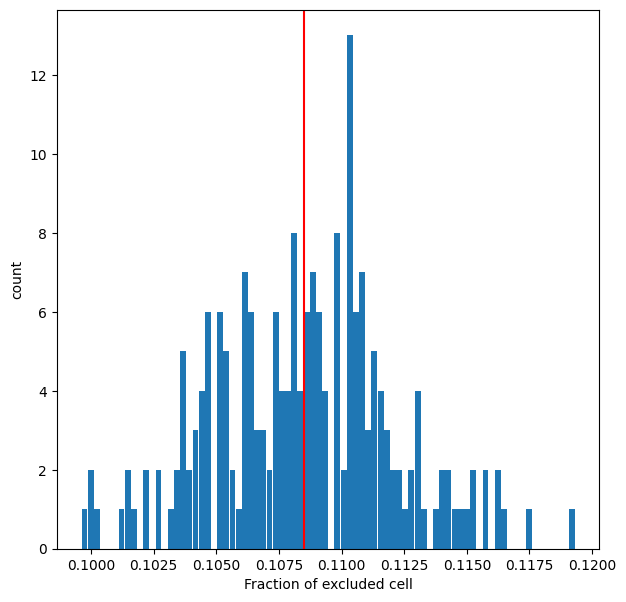

In [26]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
data       = fraction_of_exclude
bins       = 80#int(np.sqrt(data.shape[0])) -1
y,binEdges = np.histogram(data,bins=bins)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
menStd     = np.sqrt(y)
width      = .000235
plt.bar(bincenters, y, width=width)#, yerr=menStd)
plt.axvline(x=fraction_of_exclude.mean() ,color='red')
plt.xlabel(f"Fraction of excluded cell")
plt.ylabel("count")
#plt.show()
plt.savefig('./Fraction.png')

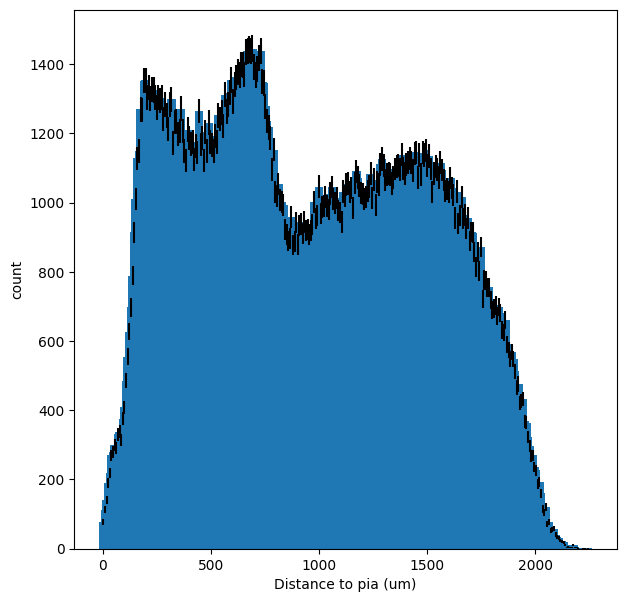

In [27]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
data       = distances_to_pia
bins       = 300#int(np.sqrt(data.shape[0])) -1
y,binEdges = np.histogram(data,bins=bins)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
menStd     = np.sqrt(y)
width      = 40
plt.bar(bincenters, y, width=width, yerr=menStd)
plt.xlabel("Distance to pia (um)")
plt.ylabel("count")
#plt.show()
plt.savefig('./Distance_to_pia.png')

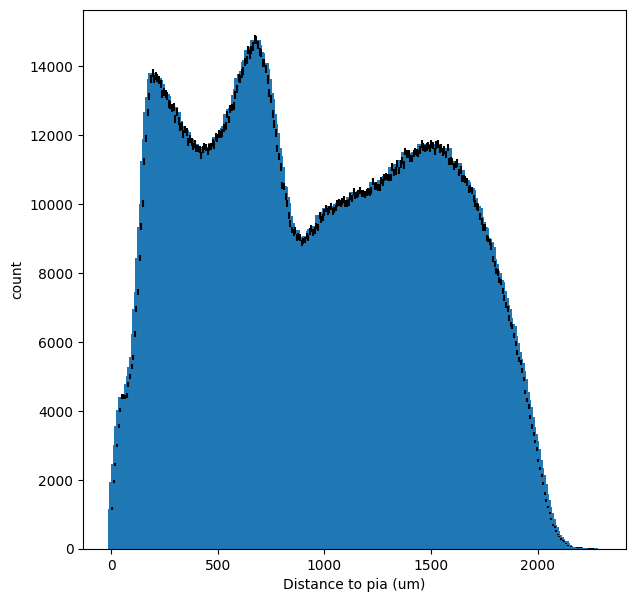

In [28]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
data       = slice_df['Distance to annotation with Outside Pia µm']
bins       = 300#int(np.sqrt(data.shape[0])) -1
y,binEdges = np.histogram(data,bins=bins)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
menStd     = np.sqrt(y)
width      = 40
plt.bar(bincenters, y, width=width, yerr=menStd)
plt.xlabel("Distance to pia (um)")
plt.ylabel("count")
#plt.show()
plt.savefig('./Distance_to_pia.png')

In [39]:
!pwd

/gpfs/bbp.cscs.ch/project/proj53/Software/rat_sscx_nissl_analysis/Notebooks
